In [2]:
from pprint import PrettyPrinter

import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import optax as ox
from jax import jit
from jax.config import config
from jaxutils import Dataset
import jaxkern as jk

import gpjax as gpx

# Enable Float64 for more stable matrix inversions.
config.update("jax_enable_x64", True)
pp = PrettyPrinter(indent=4)
key = jr.PRNGKey(123)

# Dataset

In [3]:
n = 100
noise = 0.3

x = jr.uniform(key=key, minval=-3.0, maxval=3.0, shape=(n,)).sort().reshape(-1, 1)
f = lambda x: jnp.sin(4 * x) + jnp.cos(2 * x)
signal = f(x)
y = signal + jr.normal(key, shape=signal.shape) * noise

D = Dataset(X=x, y=y)

xtest = jnp.linspace(-3.5, 3.5, 500).reshape(-1, 1)
ytest = f(xtest)

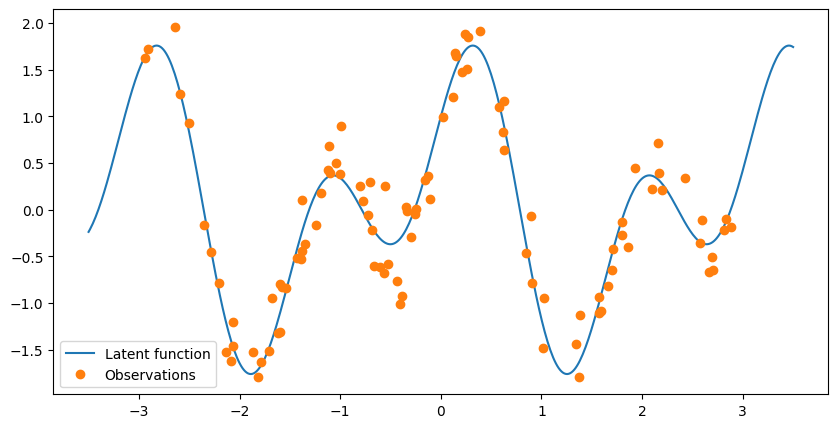

In [4]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(xtest, ytest, label="Latent function")
ax.plot(x, y, "o", label="Observations")
ax.legend(loc="best")

In [5]:
kernel = jk.RBF()
prior = gpx.Prior(kernel=kernel)

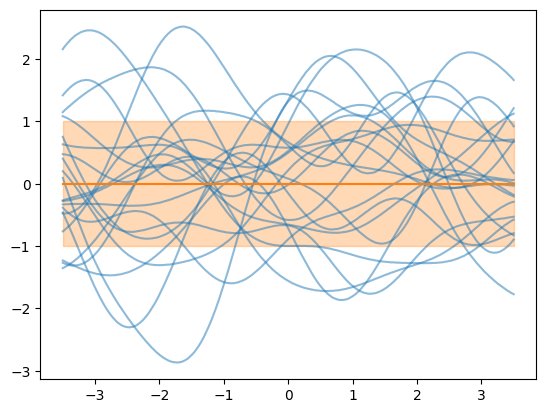

In [6]:
parameter_state = gpx.initialise(prior, key)
prior_dist = prior(parameter_state.params)(xtest)

prior_mean = prior_dist.mean()
prior_std = prior_dist.stddev()
samples = prior_dist.sample(seed=key, sample_shape=(20,)).T

plt.plot(xtest, samples, color="tab:blue", alpha=0.5)
plt.plot(xtest, prior_mean, color="tab:orange")
plt.fill_between(
    xtest.flatten(),
    prior_mean - prior_std,
    prior_mean + prior_std,
    color="tab:orange",
    alpha=0.3,
)
plt.show()

# Train

In [7]:
likelihood = gpx.Gaussian(num_datapoints=D.n)

In [8]:
posterior = prior * likelihood

In [9]:
parameter_state = gpx.initialise(
    posterior, key, kernel={"lengthscale": jnp.array([0.5])}
)
print(type(parameter_state))

<class 'gpjax.parameters.ParameterState'>


In [10]:
params, trainable, bijectors = parameter_state.unpack()
pp.pprint(params)

{   'kernel': {   'lengthscale': Array([0.5], dtype=float64),
                  'variance': Array([1.], dtype=float64)},
    'likelihood': {'obs_noise': Array([1.], dtype=float64)},
    'mean_function': {}}


In [11]:
negative_mll = jit(posterior.marginal_log_likelihood(D, negative=True))
negative_mll(params)

Array(113.9804237, dtype=float64)

In [16]:
optimiser = ox.adam(learning_rate=0.01)

inference_state = gpx.fit(
    objective=negative_mll,
    parameter_state=parameter_state,
    optax_optim=optimiser,
    num_iters=500,
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 258.63it/s, Objective=34.92]


In [17]:
learned_params, training_history = inference_state.unpack()

pp.pprint(learned_params)

{   'kernel': {   'lengthscale': Array([0.4482576], dtype=float64),
                  'variance': Array([1.38353999], dtype=float64)},
    'likelihood': {'obs_noise': Array([0.06315212], dtype=float64)},
    'mean_function': {}}


In [18]:
latent_dist = posterior(learned_params, D)(xtest)
predictive_dist = likelihood(learned_params, latent_dist)

predictive_mean = predictive_dist.mean()
predictive_std = predictive_dist.stddev()

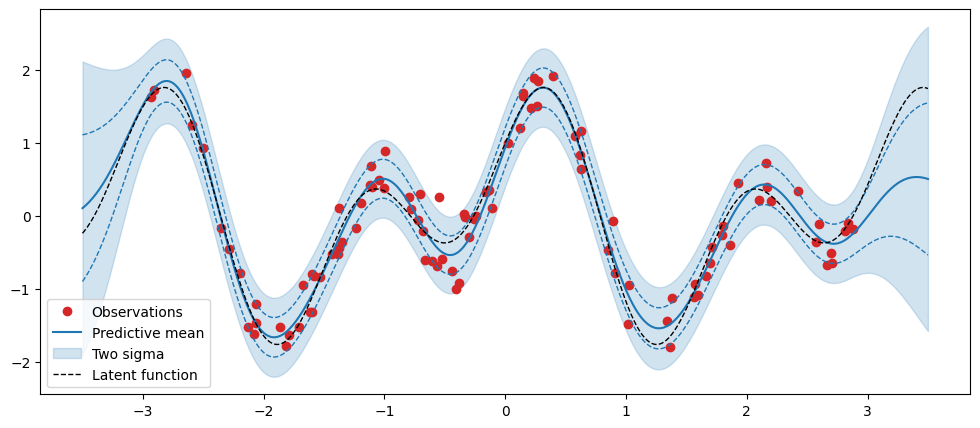

In [19]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(x, y, "o", label="Observations", color="tab:red")
ax.plot(xtest, predictive_mean, label="Predictive mean", color="tab:blue")
ax.fill_between(
    xtest.squeeze(),
    predictive_mean - 2 * predictive_std,
    predictive_mean + 2 * predictive_std,
    alpha=0.2,
    color="tab:blue",
    label="Two sigma",
)
ax.plot(
    xtest,
    predictive_mean - predictive_std,
    color="tab:blue",
    linestyle="--",
    linewidth=1,
)
ax.plot(
    xtest,
    predictive_mean + predictive_std,
    color="tab:blue",
    linestyle="--",
    linewidth=1,
)

ax.plot(
    xtest, ytest, label="Latent function", color="black", linestyle="--", linewidth=1
)

ax.legend()